## Taxi Trip Duration
1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain your system


## Frame the problem and look at the big picture

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. 
In this project the goal is to make a model based on individual trip attributes, to be able to predict the duration of each trip in the test set.

[New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)


#### The initial data from Kaggle.

Data description has following columns:

* **id** - a unique identifier for each trip
* **vendor_id** - a code indicating the provider associated with the trip record
* **pickup_datetime** - date and time when the meter was engaged
* **dropoff_datetime** - date and time when the meter was disengaged
* **passenger_count** - the number of passengers in the vehicle (driver entered value)
* **pickup_longitude** - the longitude where the meter was engaged
* **pickup_latitude** - the latitude where the meter was engaged
* **dropoff_longitude** - the longitude where the meter was disengaged
* **dropoff_latitude** - the latitude where the meter was disengaged
* **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and   forward; N=not a store and forward trip)
* **trip_duration** - duration of the trip in second


## Import The Data.

In [1]:
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import warnings
warnings.filterwarnings(action="ignore", message="^RuntimeWarning")

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import os
import tarfile
from six.moves import urllib

TAXI_PATH = os.path.join("data", "taxi")

def load_taxi_data(taxi_path=TAXI_PATH):
    csv_path = os.path.join(taxi_path, "train.csv")
    return pd.read_csv(csv_path)

In [2]:
train = load_taxi_data()
csv_path = os.path.join(TAXI_PATH, "test.csv")
test = pd.read_csv(csv_path)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Visualising The Data.

#### Pickups and dropoffs of trips in New York City with a heatmap.

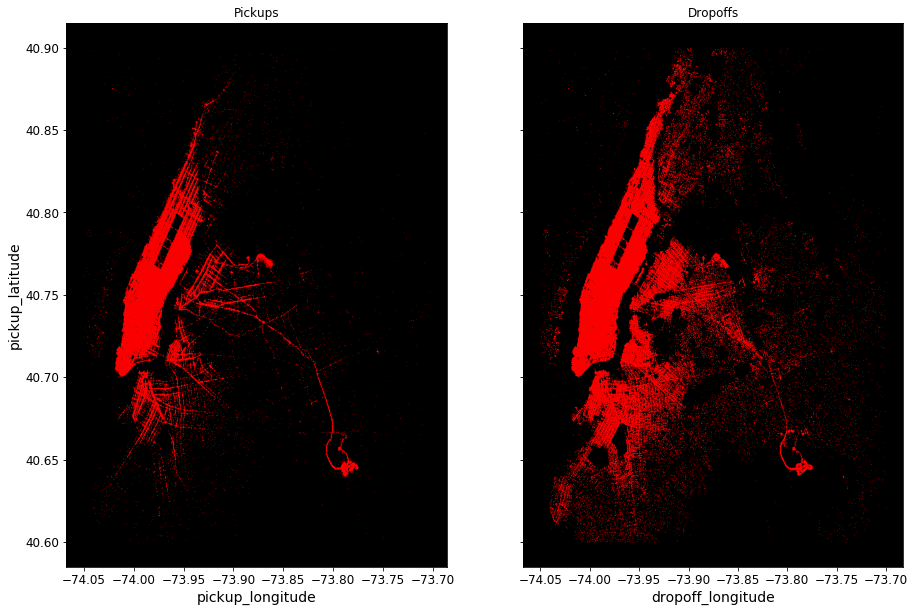

In [3]:
df = train.loc[(train.pickup_latitude > 40.6) & (train.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='red', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='red', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

As we can se in the above map - most of the journeys have been from and to manhattan.
There are two airports, John F. Kennedy and LA Guardia Airport in queens which has a good amount of taxi trips from and too. 
When calculating the euclidean distance the distance will be hugely afftected by the taxi trips that start in manhattan and ends outside manhattan.

#### Viewing the pickups and dropoffs of trips in folium.

In [4]:
import folium 

newyork_map = folium.Map(location=[40.767937,-73.982155 ], tiles='OpenStreetMap', zoom_start=12)

def createMap(geo_map, data, i=100):
    for each in train[:i].iterrows():
        p1 = [each[1]['pickup_latitude'] ,each[1]['pickup_longitude']]
        p2 = [each[1]['dropoff_latitude'], each[1]['dropoff_longitude']]
        folium.CircleMarker(p1,
                            radius=3,
                            color='blue',
                            popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.CircleMarker(p2,
                            radius=3,
                            color='red',
                            popup=str(each[1]['dropoff_latitude'])+','+str(each[1]['dropoff_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.PolyLine(locations=[p1, p2], color='green').add_to(geo_map)
    
createMap(newyork_map, train)

newyork_map

Alot of the taxi-trips starts and ends in manhattan. Lets find out how many.

In [5]:
def manh_checker(x):
    return 40.7091 < x['dropoff_latitude'] < 40.8205 and \
    -74.0096 < x['dropoff_longitude'] < -73.9307 and \
    40.7091 < x['pickup_latitude'] < 40.8205 and \
    -74.0096 < x['pickup_longitude'] < -73.9307
   
#test = train.apply(manh_checker, axis = 1) 
#print(test.sum()*100 / len(train))

So 80% of all journeys start and end in (or slighlty around) Manhattan island. The manhattan distance can give a better estimate of the distance. We will come back to that. 

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


1. There is an outlier where the passenger count is 0. We need to remove that.
2. There is also a minimum trip duration of 1 second, those trips are going nowhere and the maximum is 35,26,282 seconds.
There is some outliers here which I will remove later.

In [7]:
print(test.isnull().sum(axis=0).sum(axis=0))
print(train.isnull().sum(axis=0).sum(axis=0))

0
0


There are no missing values which is good.

In [8]:
#durations_longer_than_4timer = train.query("trip_duration > 10800").groupby(["trip_duration"]).size()
#long_durations = pd.DataFrame({'id'}:durations_longer_than_4timer))

#### Trip duration 

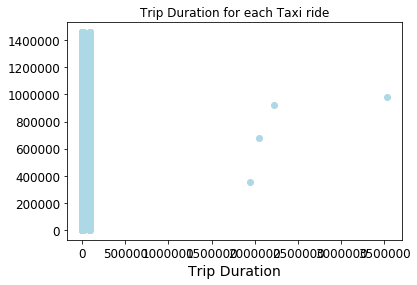

In [9]:
plt.scatter(train.trip_duration,train.index,color="lightblue")
plt.xlabel("Trip Duration")
plt.title("Trip Duration for each Taxi ride");

Looks like some trips are going too far away from New York city(Long rides who knows). These are outliers. Since the evaluation metrics is RMSLE(Root Mean Squared Logarithmic Error), we can log transform trip duration and use RMSE(Root Mean Squared Error) for training.
The graph is skewed to the right. From this graph I cannot tell where the mean is. The graph does not explain the data well. We can do a log transform to have a better look. The log transformation will make highly skewed distributions less skewed. 

In [10]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

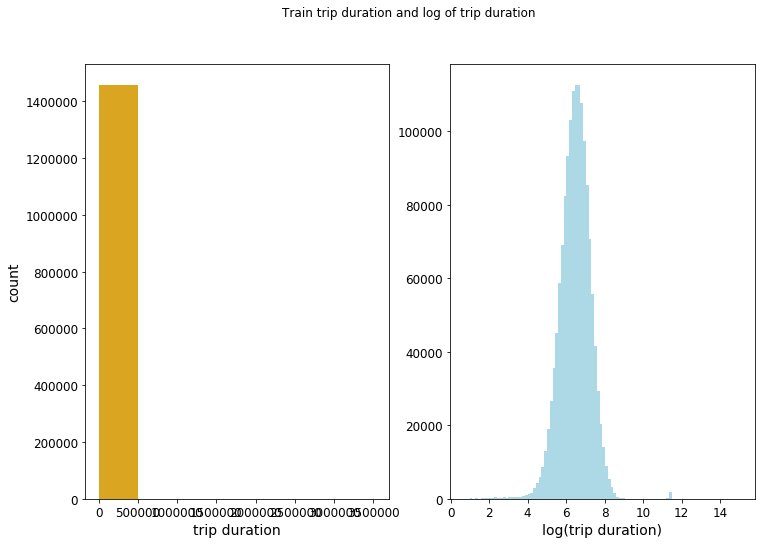

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Train trip duration and log of trip duration')
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax1.hist(train.trip_duration,bins=7, color="goldenrod")
ax2.hist(train.log_trip_duration,bins=100, color="lightblue");

There we go, now its better. Lets have a look at the skewness and kurtosis.

In [12]:
print("Skewness: %f" % train['log_trip_duration'].skew())
print("Kurtosis: %f" % train['log_trip_duration'].kurt())

Skewness: -0.290161
Kurtosis: 3.859302


1. Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.
2. Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case. 

From what we can see in the histogram to the left there are some points that falls outside the bellcurve. These are the outliers I mentioned earlier. These taxi trips have a really long trip duration. But it doesnt necessarily mean that they are outliers and should be removed. Because it could be trips where they are stuck in really bad traffic. On for example hollydays the traffic can be huge, not to mention black friday.

From earlier we found out that the maximum trip duration was about 100 hours. Lets have a closer look to find out wether there are more outliers.

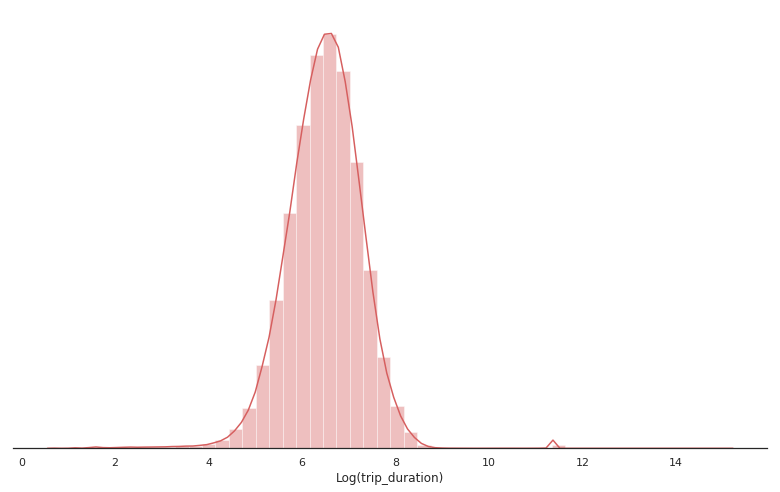

In [13]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

There are a few trips that are very large and are more than 3 standard deviations away from the mean. These can be far away from new york. Lets have a close look.

Time taken by above cell is 9.879749536514282.


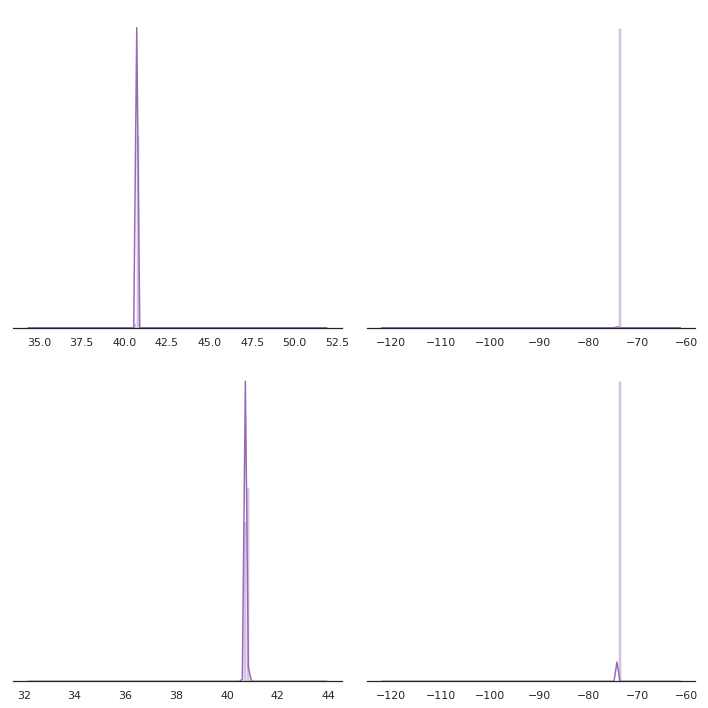

In [14]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

The pick and drop latidude are centered around 40 to 41, and longitude are around -74, -73
the sns is getting affected by the outliers. Trips that are far away have affected this plot. As we can see there are location from 32 tp 44 and -120 to -60. These are affecting the model and will not give us a better estimate on trips in New York. The data is not well descibed by the normal distrubtion.
If we contrain the locations to only be in New York City we can get a better understanding. 

Time taken by above cell is 12.324336051940918.
1452385 1458644


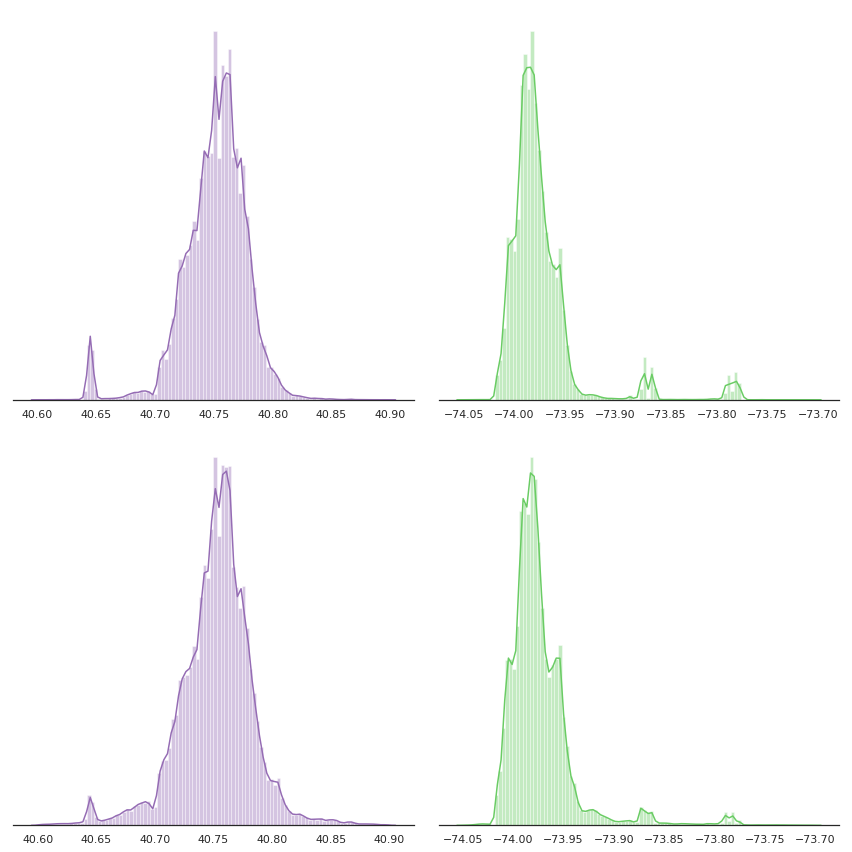

In [15]:
start = time.time()
df = train.loc[(train.pickup_latitude > 40.6) & (train.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
print(df.shape[0], train.shape[0])
plt.show()

1. latitude should be between 40.6 to 40.9
2. Longitude should be between -74.05 to -73.70
We can see that most of the trips are getting concentrated between these lat-long only. 
The trips that are far away from newyork should not be in the dataset since we are focusing on trip duration in  New York City. 
Removing these will give as a better model prediction. 

Notice that location around -73.90 and 40.65 is the location of the John F. Kennedy Airport and -74 which is manhattan where 80% of the trips accoured. This is good. This graph have a better explanation of the population(taxi trips).
By removing the trips outside New York city the model becomes a better estimator of the mew.  

#### Lets have a look at the two different vendors.

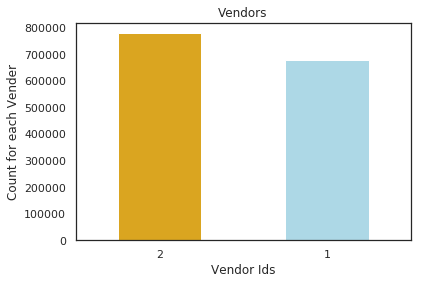

In [16]:
train["vendor_id"].value_counts().plot(kind='bar',color=["goldenrod","lightblue"])
plt.xticks(rotation='horizontal')
plt.title("Vendors")
plt.ylabel("Count for each Vender")
plt.xlabel("Vendor Ids");

Only 2 Vendors are there, they can be representing 2 taxi companies. Vendor 2 has more share in taxi rides in New York city. 

How many passengers are traveling together?

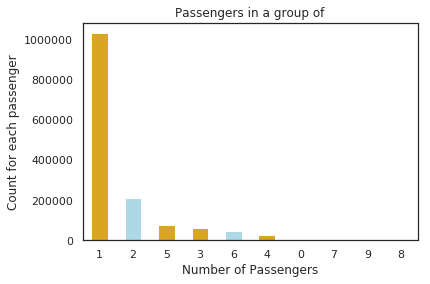

In [17]:
train["passenger_count"].value_counts().plot(kind='bar',color=["goldenrod","lightblue"])
plt.title("Passengers in a group of")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for each passenger")
plt.xlabel("Number of Passengers");

Most popular choice of travel is single.
2nd popular way of ride is with a single friend.
May be for long cars popular choice of travel is in group of 5 and then in group of 6 people.

In [18]:
train.groupby('passenger_count').size()

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
dtype: int64

In [19]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

There are some outliners here. We have 53 and 23 trips with zero passengers. There is also two trips with 9 passengers. 
Other than that the data seems to match relatively between the two data sets.

#### Passenger count vs trip_duration


No handles with labels found to put in legend.


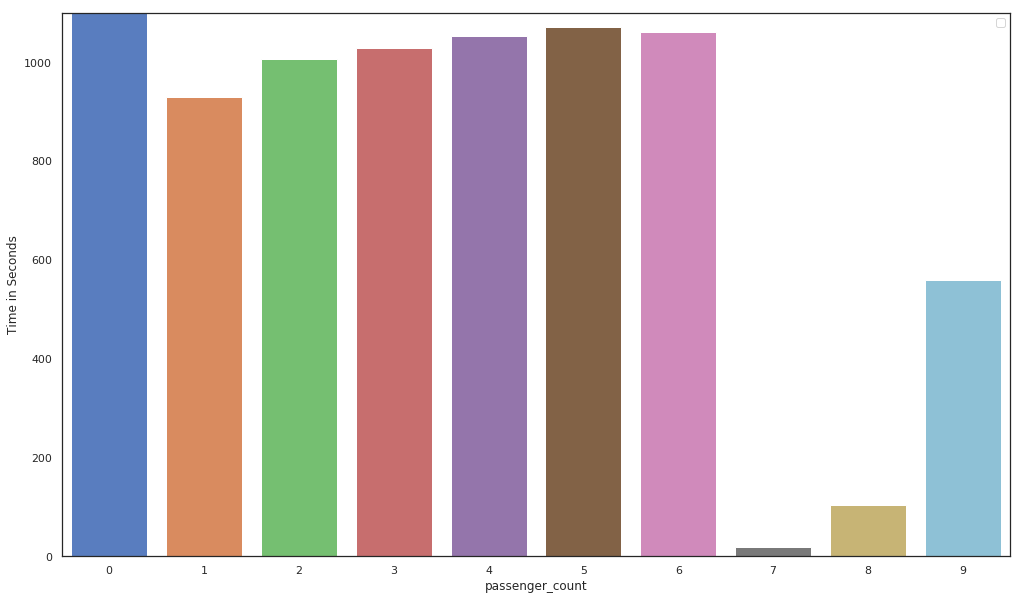

In [20]:
pc = train.groupby('passenger_count')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

The time goes slightly up with the number of passenger increasing but nothing significant. Which is interesting because the more passengers the more stops. Unless they are all going to the same place. Which in this set it seems that they do.

#### Whether the Trip Details are Stored Or Forwarded?

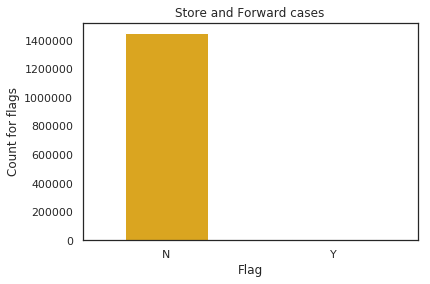

In [21]:
train["store_and_fwd_flag"].value_counts().plot(kind='bar', color=["goldenrod","lightblue"])
plt.title("Store and Forward cases")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for flags")
plt.xlabel("Flag");

Almost all the journey details were immediately sent to vendors. Very few stored in device memory may be due to bad signal or bad weather.

## Feature Engineering

We can extract lot of insights from dates and time data we have.

1. Pickup hour rushes can define start of office timings and drop offs in evening can tell till what time New Yorkers work.
2. Weekdays and weekends can show another angle of city life. Weekends people will be getting up late and starting day late compared to weekdays. Also parties can go beyond midnight hours on weekends.
3. We can also look out for some kind of seasonality. For example, during winter seasons traffic will be going slow due to snowfalls or wetness on Roads. So, trip Duration will be longer in winters than other seasons.
4. Finding out wether it is a holiday or for example if it is black friday that will have an inpact on the trip duration.

#### Dropping zero trip duration and passengers.

In [22]:
train = train[train.passenger_count != 0]
test = test[test.passenger_count != 0]
test = test[test.passenger_count != 9]
train = train[train.trip_duration != 0]

#### Date Extraction
Extraction out the date time to multiple variables enables us to do one hot encoding. Ml models understands 0's and 1's istead of januar and februar
Also by doing this we can get a better understanding of for example a given hour if it is rush or not

In [23]:
dr = pd.date_range(start='2016-01-01', end='2016-12-31')
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

train['pickup_datetime']             = pd.to_datetime(train.pickup_datetime)
train['holiday']                     = train['pickup_datetime'].isin(holidays)
train['dropoff_datetime']            = pd.to_datetime(train.dropoff_datetime) # Not in Test

train['pickup_weekday']              = pd.to_datetime(train.pickup_datetime).dt.dayofweek.astype('uint8')
train['pickup_day']                  = pd.to_datetime(train.pickup_datetime).dt.day.astype('uint8')
train['pickup_hour']                 = pd.to_datetime(train.pickup_datetime).dt.hour.astype('uint8')
train['pickup_minute']               = pd.to_datetime(train.pickup_datetime).dt.minute.astype('uint8')
train['pickup_second']               = pd.to_datetime(train.pickup_datetime).dt.second.astype('uint8')
train["pickup_dayofyear"]            = pd.to_datetime(train.pickup_datetime).dt.dayofyear.astype('uint8')
train['pickup_month']                = pd.to_datetime(train.pickup_datetime).dt.month.astype('uint8')

train['pickup_dt']                   = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour']            = train['pickup_weekday'] * 24 + train['pickup_hour']

In [24]:
test['pickup_datetime']              = pd.to_datetime(test.pickup_datetime)
test['holiday']                      = test['pickup_datetime'].isin(holidays)
test['pickup_weekday']               = pd.to_datetime(test.pickup_datetime).dt.dayofweek.astype('uint8')
test['pickup_day']                   = pd.to_datetime(test.pickup_datetime).dt.day.astype('uint8')
test['pickup_hour']                  = pd.to_datetime(test.pickup_datetime).dt.hour.astype('uint8')
test['pickup_minute']                = pd.to_datetime(test.pickup_datetime).dt.minute.astype('uint8')
test['pickup_second']                = pd.to_datetime(test.pickup_datetime).dt.second.astype('uint8')
test["pickup_dayofyear"]             = pd.to_datetime(test.pickup_datetime).dt.dayofyear.astype('uint8')
test['pickup_month']                 = pd.to_datetime(test.pickup_datetime).dt.month.astype('uint8')

test['pickup_dt']                    = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour']             = test['pickup_weekday'] * 24 + test['pickup_hour']

In [25]:
# Converting holiday to 0 or 1
train['holiday'] = 1 * (train.store_and_fwd_flag.values == False)
test['holiday'] = 1 * (test.store_and_fwd_flag.values == True)

### Now that the dates has been extracted. Lets have a look at them on the graphs - Visualising The Dates.

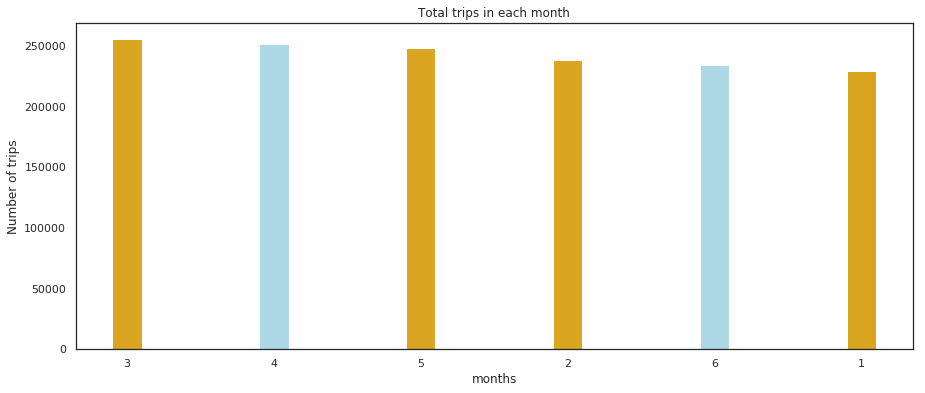

In [26]:
plt.figure(figsize=(15, 6)) 
train.pickup_month.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.2)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");


We have data from January to June of 2016. Highest number of trips happened in March and lowest in January.

#### Month and Trip Durations Together with Vendor Contribution
Since we have kernel memory limit , I have taken subset of data

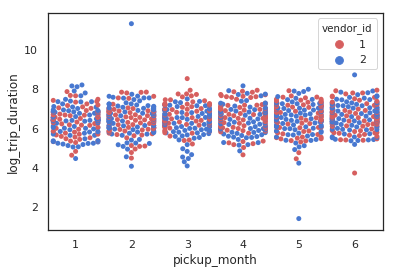

In [27]:
sns.swarmplot(train.pickup_month[:1000],train.log_trip_duration[:1000],hue=train.vendor_id[:1000],palette={1:'r',2:'b'});

1. Vendors contribution is apporoximately same. 
1. There is linear relationship between Month and Trip Duration.

#### Total trips 

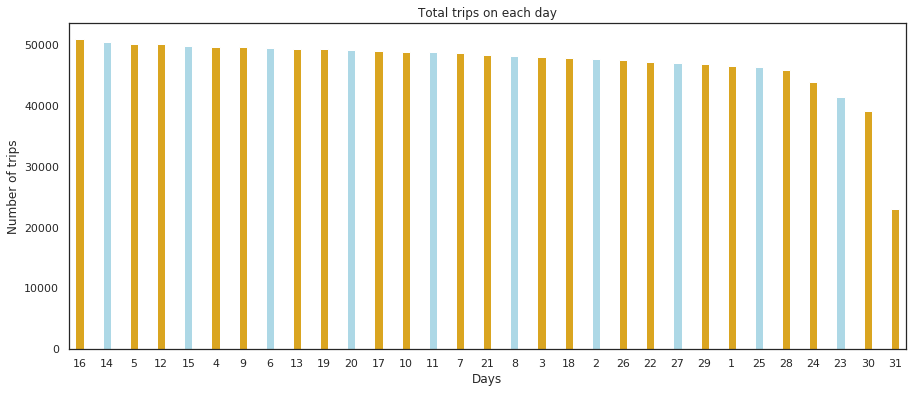

In [28]:
plt.figure(figsize=(15, 6)) 
train.pickup_day.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.3)
plt.xlabel("Days")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each day");

1. Highest number of trips happened on 16th of the month while lowest on 31st.
2. 30th and 31st have less trips because we have 6 months data and 30th and 31st came only 3 times each.



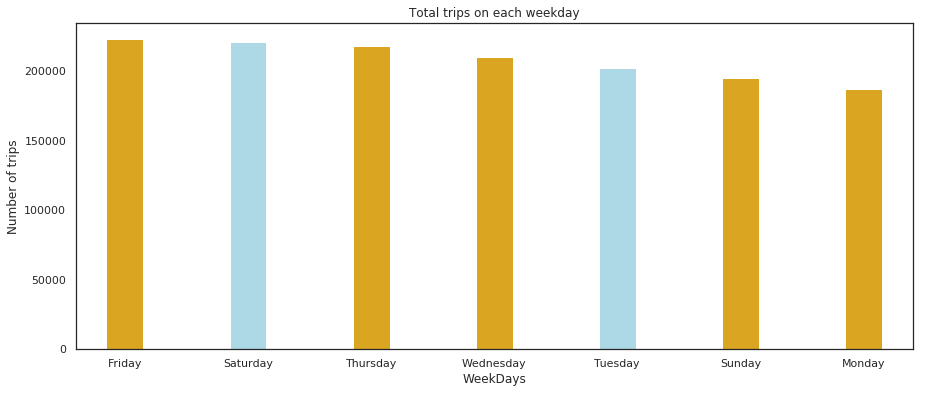

In [29]:
plt.figure(figsize=(15, 6)) 
train['pickup_datetime'].dt.weekday_name.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.3)
plt.xlabel("WeekDays")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each weekday");

Highest number of trips took place on every Friday of the week while lowest on Mondays.

#### Let's check the average time taken by two different vendors vs weekday

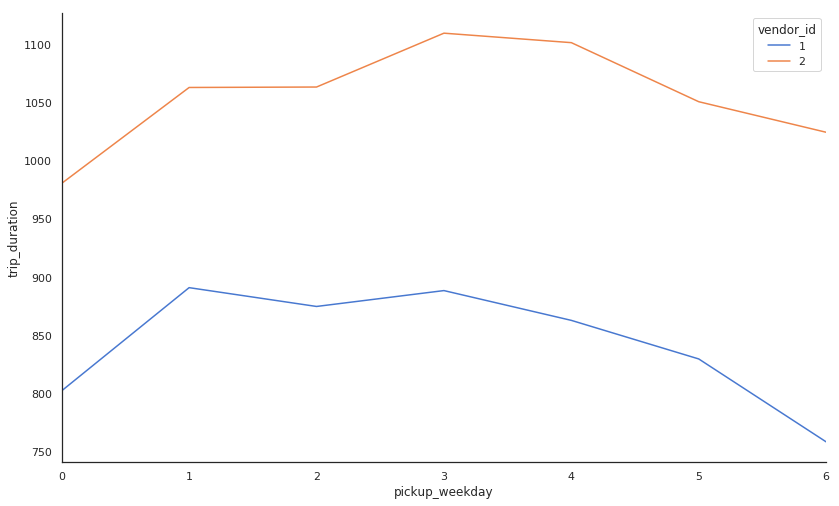

In [30]:
import warnings
warnings.filterwarnings("ignore")
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','pickup_weekday'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set_context("poster")
sns.set(style="white", palette="muted", color_codes=False, rc={'figure.figsize':(13.7,8.27)})
sns.tsplot(data=summary_wdays_avg_duration, time="pickup_weekday", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

it's clear that the vendor 1 is taking more time than vendor 2 on all the days of the week. The difference between the average time taken by vendor 1 is ~250 seconds more than vendor 2.

#### Taxi Trips By Dropoff Hour

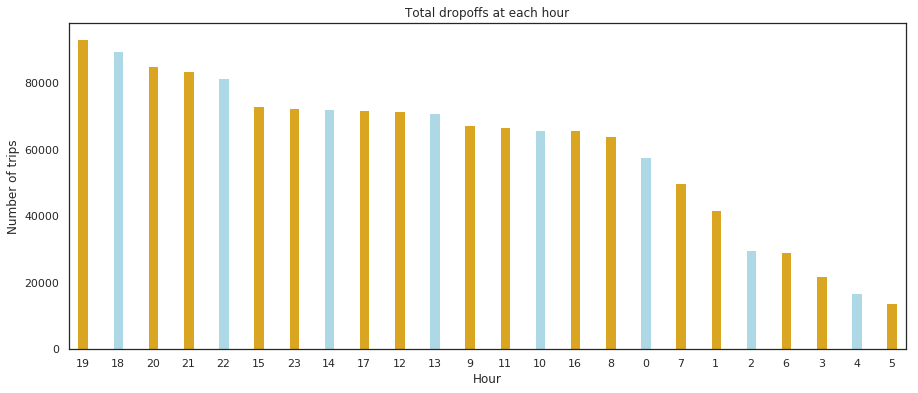

In [31]:
plt.figure(figsize=(15, 6)) 
train['dropoff_datetime'].dt.hour.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("Hour")
plt.ylabel("Number of trips")
plt.title("Total dropoffs at each hour");

The highest number of dropoffs were at 19:00 and the lowest were at 05:00.

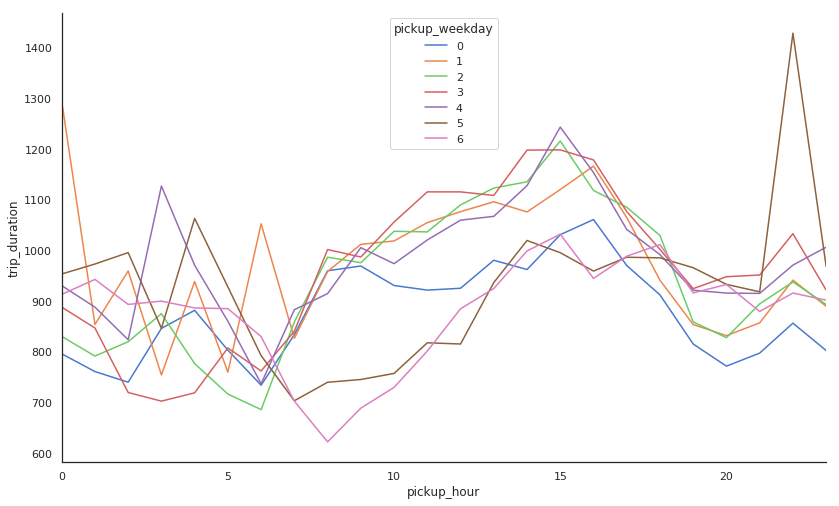

In [32]:
summary_hour_duration = pd.DataFrame(train.groupby(['pickup_weekday','pickup_hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False, rc={'figure.figsize':(13.7,8.27)})
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="pickup_weekday", value="trip_duration")
sns.despine(bottom = False)

* On Sunday (0) and day Saturday (6), the trip duration is less that all the weekdays at 5 AM to 15 AM time.
* See this, on Saturday around midnight, the taxi trips are taking far more than usual time.


Lets Convert store and forward flag to 0 or 1 so the algorithms can understand them. 

In [33]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

### Calculate Distance and Speed

Calculations of the distances takes some time. So I have moved the calculation to create_distance_csv.ipynb. I have calculated the manhattan, euclidean and haversine distance. I have added their logarithms as well. Now lets import them and merge them with our dataset.

#### Distance

In [34]:
TAXI_PATH = os.path.join("data", "taxi")
csv_path = os.path.join(TAXI_PATH, "train_distance.csv")
train_distance = pd.read_csv(csv_path, index_col=0)

csv_path = os.path.join(TAXI_PATH, "test_distance.csv")
test_distance = pd.read_csv(csv_path, index_col=0)

In [35]:
train = train.join(train_distance.set_index('id'), on='id')
test = test.join(test_distance.set_index('id'), on='id')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_second,pickup_dayofyear,pickup_month,pickup_dt,pickup_week_hour,haversine_distance,euclidean_distance,log_euclidean_distance,manhattan_distance,log_manhattan_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,...,55,74,3,6369878.00,17,1.50,0.02,0.02,1.74,1.01
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,...,35,164,6,14085798.00,144,1.81,0.02,0.02,2.43,1.23
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,...,24,19,1,1596907.00,35,6.39,0.06,0.06,8.20,2.22
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,...,31,97,4,8364734.00,67,1.49,0.01,0.01,1.66,0.98
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,...,55,86,3,7392638.00,133,1.19,0.01,0.01,1.20,0.79


#### The fastest route - OSRM
I wanted to download the distances between the locations from google. But I have 1.4 millions of entries and I dont think google would like a api call like that. So I found another way to do it. There is an opensource algorithm - Open Source Routing Machine that can do it for me for free. There is already a csv on the internet which has an estimate of the total distance on this dataset.
Which I am thankfull for. This will make a better estimate of the distance than manhattan and haversine - distance. 


In [36]:
TAXI_PATH = os.path.join("data", "taxi")
csv_path_part1 = os.path.join(TAXI_PATH, "fastest_routes_train_part_1.csv")
csv_path_part2 = os.path.join(TAXI_PATH, "fastest_routes_train_part_2.csv")
csv_path_test = os.path.join(TAXI_PATH, "fastest_routes_test.csv")
cols = ['id', 'total_distance', 'total_travel_time',  'number_of_steps']

fastest_routes1 = pd.read_csv(csv_path_part1, usecols = cols)
fastest_routes2 = pd.read_csv(csv_path_part2, usecols = cols)
test_fastest_routes = pd.read_csv(csv_path_test, usecols = cols)

train_fastest_routes = pd.concat((fastest_routes1, fastest_routes2))


In [37]:
train_fastest_routes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458643 entries, 0 to 758642
Data columns (total 4 columns):
id                   1458643 non-null object
total_distance       1458643 non-null float64
total_travel_time    1458643 non-null float64
number_of_steps      1458643 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 55.6+ MB


* **number_of_steps** is the route steps for each route - which means how many right and left turns
* **total_distance** - The shortest distance between to points. It does not depend on other variables. For example traffic data. Assuming the taxi drivers knows the shortest paths around the city. But there is always a chance that the driver takes a longer path.
* **total_travel_time** - estimates the total travel time based on distance and speed. 
* **id** - id for the taxi to match the dataset.

Lets merge the new data into our dataset.

In [38]:
train = train.merge(train_fastest_routes, how='left', on='id')
test = test.merge(test_fastest_routes, how='left', on='id')

#### Speed

In [39]:
train.loc[:, 'avg_speed_h'] = 1000 * train['haversine_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['manhattan_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_eu'] = 1000 * train['euclidean_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_osrm'] = train['total_distance'] / train['trip_duration']

test.loc[:, 'avg_speed_h'] = 1000 * test['haversine_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_m'] = 1000 * test['manhattan_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_eu'] = 1000 * test['euclidean_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_osrm'] = test['total_distance'] / train['trip_duration']
print(train.isnull().sum(axis=0).sum(axis=0))
print(test.isnull().sum(axis=0).sum(axis=0))

4
0


In [40]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_euclidean_distance,manhattan_distance,log_manhattan_distance,total_distance,total_travel_time,number_of_steps,avg_speed_h,avg_speed_m,avg_speed_eu,avg_speed_osrm
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,...,0.02,1.74,1.01,2009.10,164.90,5.00,3.29,3.81,0.04,4.42
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,...,0.02,2.43,1.23,2513.20,332.00,6.00,2.72,3.67,0.03,3.79
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,...,0.06,8.20,2.22,11060.80,767.60,16.00,3.01,3.86,0.03,5.21
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,...,0.01,1.66,0.98,1779.40,235.80,4.00,3.46,3.87,0.03,4.15
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,...,0.01,1.20,0.79,1614.90,140.10,5.00,2.73,2.76,0.02,3.71


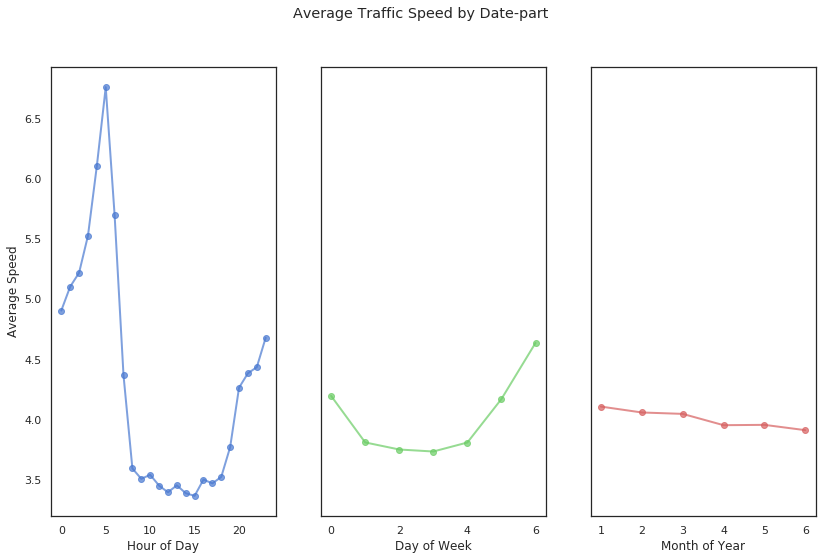

In [41]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

* Most of the travelling in the Big Apple happens during work hours. 
* The average speed by weekday follows an expected trend. 
* Over the weekend (Friday, Saturday, Sunday) the average speed picks up quite nicely, indicating less traffic.
* The winter months there are less trips indicating less traffic in general in the city.

#### Average speed for regions in New York.

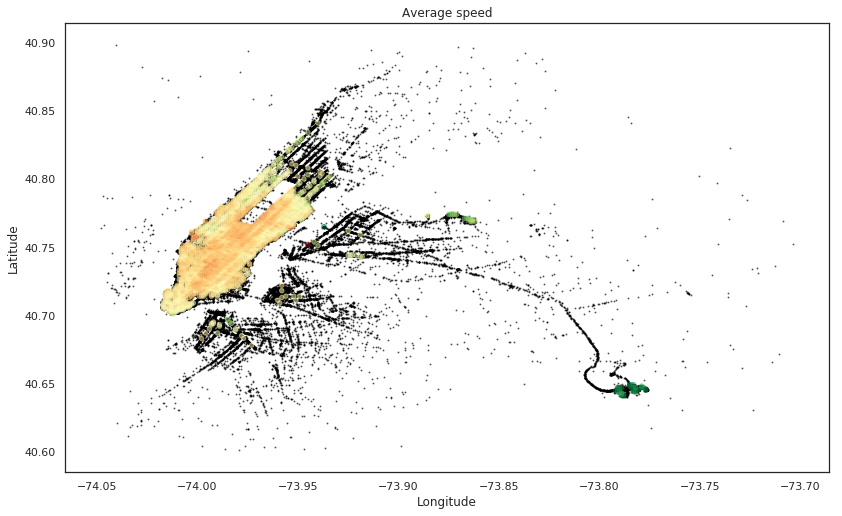

In [43]:
df = train.loc[(train.pickup_latitude > 40.6) & (train.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()

train.loc[:, 'pickup_lat_bin'] = np.round(train_data_new['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train_data_new['pickup_longitude'], 3)
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train_data_new.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train_data_new.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train_data_new.pickup_longitude.values[:500000], train_data_new.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

From the scatter plot we can se that in manhattan there is more traffic indicating a lower average speed.

## Model and Prediction 

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [45]:
train_samples = train.sample(n=round(0.15*len(train.index))) # 15 % of the training data.
target = train_samples.log_trip_duration.values
train_samples = train_samples.drop(['id', 'pickup_datetime', 'haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime', 'trip_duration','log_trip_duration','pickup_dt'], axis=1)
train_samples.fillna(0,inplace=True)

In [46]:
test_samples = test.sample(n=round(0.15*len(test.index))) # 15 % of the training data.
Id=test.id.values
test_samples = test_samples.drop(['id','pickup_datetime','pickup_dt','haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu'], axis=1)
test.fillna(0,inplace=True)
predictors=test_samples.columns

In [47]:
feature_names = list(train_samples.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(test_samples.columns, train_samples.columns)))
print("")
do_not_use_for_training = ['id', 'pickup_datetime', 'haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime', 'trip_duration','log_trip_duration','pickup_dt']
feature_names = [f for f in test_samples.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))


Difference of features in train and test are []

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'holiday', 'pickup_weekday', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_second', 'pickup_dayofyear', 'pickup_month', 'pickup_week_hour', 'log_euclidean_distance', 'log_manhattan_distance', 'total_distance', 'total_travel_time', 'number_of_steps', 'avg_speed_osrm'].

Total number of features are 22.


#### Splitting to train and validation set

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_samples, target, random_state=42, test_size = 0.2)

In [49]:
rf_clf = RandomForestRegressor(n_estimators=250, max_depth=30, random_state=42, n_jobs=-1)
rf_clf.fit(X_train.values, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [50]:
rf_clf.score(X_test, y_test)

0.9786967007865537

#### Feature importances

In [51]:
importances = rf_clf.feature_importances_

In [52]:
indices = np.argsort(importances)[::-1]

In [ ]:
for f in range(10): 
    print(f'{X_train.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

total_distance: 0.57
avg_speed_osrm: 0.28
total_travel_time: 0.11
log_euclidean_distance: 0.01
vendor_id: 0.0
log_manhattan_distance: 0.0
pickup_hour: 0.0
pickup_minute: 0.0
pickup_dayofyear: 0.0
pickup_week_hour: 0.0


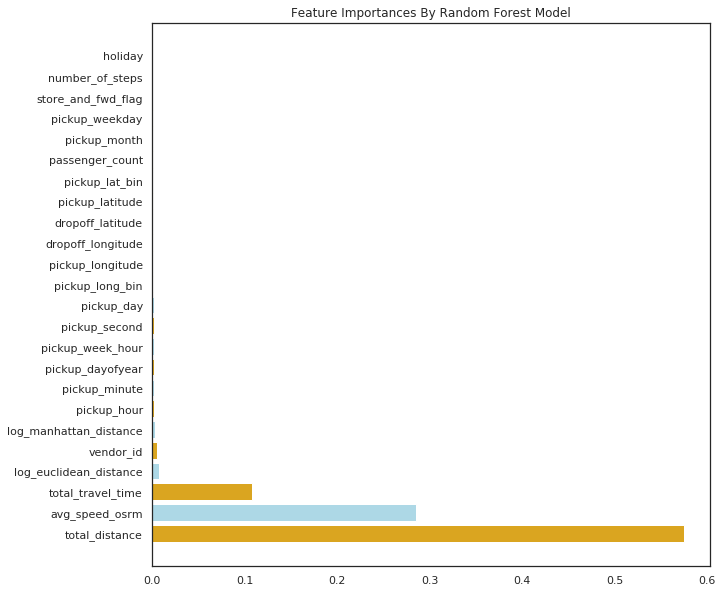

In [ ]:
predictors=train_samples.columns
importances=rf_clf.feature_importances_
std = np.std([rf_clf.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances By Random Forest Model")
plt.barh(range(len(indices)), importances[indices],
       color=["goldenrod","lightblue"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');

#### Creating a pipeline

In [ ]:
steps = [("ohe_onestep", DictVectorizer(sparse = False)), ("xgb_model", xgb.XGBRegressor())]

In [ ]:
xgb_pipeline = Pipeline(steps)

In [ ]:
final_predictions = rf_clf.predict(X_test)

#### Final scores

In [ ]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.1156330526269123


The model can be overfitting. I have tried cross val but I dont really get it to work.
I will aslo try with xgboost. Xgboost is a good model it has built in protection against overfitting.

#### Testing with xgboost

In [ ]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 80, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 25,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 20, watchlist, early_stopping_rounds=5,
                  maximize=False, verbose_eval=1)


print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:4.22615	valid-rmse:4.22735
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:2.9774	valid-rmse:2.97797
[2]	train-rmse:2.10941	valid-rmse:2.10944
[3]	train-rmse:1.51155	valid-rmse:1.51141
[4]	train-rmse:1.10427	valid-rmse:1.10454
[5]	train-rmse:0.83152	valid-rmse:0.83366
[6]	train-rmse:0.650283	valid-rmse:0.654911
[7]	train-rmse:0.476008	valid-rmse:0.48291
[8]	train-rmse:0.358637	valid-rmse:0.36732
[9]	train-rmse:0.308566	valid-rmse:0.320645
[10]	train-rmse:0.279453	valid-rmse:0.295271
[11]	train-rmse:0.262248	valid-rmse:0.281592
[12]	train-rmse:0.251859	valid-rmse:0.273821
[13]	train-rmse:0.210304	valid-rmse:0.234465
[14]	train-rmse:0.205801	valid-rmse:0.231998
[15]	train-rmse:0.180655	valid-rmse:0.208602
[16]	train-rmse:0.166601	valid-rmse:0.195097
[17]	train-rmse:0.162187	valid-rmse:0.192039
[18]	train-rmse:0.160697	valid-rmse:0.191514
[19]	train-rmse:0.15881	va

Scaling min_child_weight max_depth and number of steps gives a slightly better score. 


Xgboost gives a higher score which can mean that the randomforrest is overfitting our model. 

Now lets drop the location that are outside New York and see what kind of result we get.

In [ ]:
train_samples = train_data_new.sample(n=round(0.10*len(train.index))) # 10 % of the training data.
target = train_data_new.log_trip_duration.values
train_samples = train_data_new.drop(['id', 'pickup_datetime', 'haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime', 'trip_duration','log_trip_duration','pickup_dt'], axis=1)
train_samples.fillna(0,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_samples, target, random_state=42, test_size = 0.2)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 80, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 25,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 20, watchlist, early_stopping_rounds=5,
                  maximize=False, verbose_eval=1)


print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:4.2249	valid-rmse:4.22514
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:2.98972	valid-rmse:2.98984
[2]	train-rmse:2.11704	valid-rmse:2.11711
[3]	train-rmse:1.51812	valid-rmse:1.51852
[4]	train-rmse:1.1045	valid-rmse:1.10553
[5]	train-rmse:0.828537	valid-rmse:0.831306
[6]	train-rmse:0.649504	valid-rmse:0.655189
[7]	train-rmse:0.500819	valid-rmse:0.508727
[8]	train-rmse:0.423688	valid-rmse:0.435447
[9]	train-rmse:0.377089	valid-rmse:0.39268
[10]	train-rmse:0.317825	valid-rmse:0.335746
[11]	train-rmse:0.298077	valid-rmse:0.319341
[12]	train-rmse:0.282282	valid-rmse:0.30655
[13]	train-rmse:0.229359	valid-rmse:0.255126
[14]	train-rmse:0.19303	valid-rmse:0.21994
[15]	train-rmse:0.187699	valid-rmse:0.216697
[16]	train-rmse:0.183884	valid-rmse:0.214524
[17]	train-rmse:0.169286	valid-rmse:0.20067
[18]	train-rmse:0.166087	valid-rmse:0.199039
[19]	train-rmse:0.163758	val

This is interesting. We get a slightly worse score when dropping locations. So my initional thoughs was that these trips were outliers and should be removed. But they actually made my model predict better. Since I have calculated the total distance and speed for these location and we know the total duration. They are accounted for by the model. So by removing them I lose data which are important.

Now lets bring on the full dataset and tweek some parameters and see how xgboost does.

In [ ]:
train_df = train
target = train_df.log_trip_duration.values
train_samples = train_df.drop(['id', 'pickup_datetime', 'pickup_weekday','pickup_month','passenger_count','pickup_day','pickup_lat_bin','store_and_fwd_flag','haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime','log_trip_duration','pickup_dt'], axis=1)
train_samples.fillna(0,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_samples, target, random_state=42, test_size = 0.2)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 150, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 40,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 20, watchlist, early_stopping_rounds=5,
                  maximize=False, verbose_eval=1)


print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:4.21748	valid-rmse:4.21499
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:2.96409	valid-rmse:2.962
[2]	train-rmse:2.08924	valid-rmse:2.08755
[3]	train-rmse:1.47235	valid-rmse:1.47128
[4]	train-rmse:1.04761	valid-rmse:1.04696
[5]	train-rmse:0.736516	valid-rmse:0.736395
[6]	train-rmse:0.534725	valid-rmse:0.535164
[7]	train-rmse:0.400521	valid-rmse:0.401675
[8]	train-rmse:0.313772	valid-rmse:0.31586
[9]	train-rmse:0.259565	valid-rmse:0.262905
[10]	train-rmse:0.19374	valid-rmse:0.1978
[11]	train-rmse:0.153698	valid-rmse:0.15867
[12]	train-rmse:0.139864	valid-rmse:0.145894
[13]	train-rmse:0.113916	valid-rmse:0.120518
[14]	train-rmse:0.108179	valid-rmse:0.115496
[15]	train-rmse:0.104884	valid-rmse:0.112852
[16]	train-rmse:0.097093	valid-rmse:0.105477


9% rmse for final score. Great :D

#### Making a better model - Thoughs
To get a better prediction on the validation set. We can do some more feature engineering. Like importing the weather data to find out what kind of impact the weather has on the data. It would have been very good to find more information about the traffic - the pulse of the city. To know if a road is close or a bridge or if there has been a collision/accident.
1. Cluster the neighborhoods can be tested to see if it has an impact on the model.
2. Limit the dataset to only taxitrips within manhattan to see how well the model would have predicted taxi trips in manhattan. 
    * It would be interesting to lower the domain to see how much better the model would have done. Ofcourse it will be bad to send in the test data with a model that is based on manhattan. But for curiosity reasons it would be fun.

I have downloaded a dataset from 2016 which I was going to implement but I did not have time. Next time :D

## Submission example

In [ ]:
predictions=rf_clf.predict(test_samples.values)
predictions[:5]

In [ ]:
test['trip_duration'] = np.exp(predictions) - 1
test['id']=Id
test[['id', 'trip_duration']].to_csv('poonam.csv.gz', index=False, compression='gzip')
test['trip_duration'][:5]